# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from data_utils import get_CIFAR10_data
from implementations.layers import dropout_forward


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout in Tensorflow
Let's first try the dropout function in Tensorflow.

In [12]:
np.random.seed(15009)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  
  # please read the documentation of tf.nn.dropout carefully
  out = tf.Session().run(tf.nn.dropout(x, keep_prob=p))

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print()


Running tests with p =  0.25
Mean of input:  9.998768973493084
Mean of train-time output:  10.008899726274565
Fraction of train-time output set to zero:  0.749808

Running tests with p =  0.4
Mean of input:  9.998768973493084
Mean of train-time output:  9.969775353304142
Fraction of train-time output set to zero:  0.601128

Running tests with p =  0.7
Mean of input:  9.998768973493084
Mean of train-time output:  10.01581294251331
Fraction of train-time output set to zero:  0.29886



# Dropout forward pass
In the file `implementations/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [13]:
np.random.seed(15009)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out = dropout_forward(x, {'mode': 'train', 'p': p})

#   Hint: The tensorflow dropout does not have a mode parameter to specify the mode.
  out_test = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  9.998768973493084
Mean of train-time output:  9.986276462158349
Mean of test-time output:  9.998768973493084
Fraction of train-time output set to zero:  0.750368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.998768973493084
Mean of train-time output:  9.99260827072689
Mean of test-time output:  9.998768973493084
Fraction of train-time output set to zero:  0.600272
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.998768973493084
Mean of train-time output:  9.991168302483839
Mean of test-time output:  9.998768973493084
Fraction of train-time output set to zero:  0.300436
Fraction of test-time output set to zero:  0.0



## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
The expected outputs of the neurons at test time would not be the same as the expected outputs during training time, which would lead to poor performance. This would happen since we are setting neurons to zero with probability of 1-p, so the expected value of the neurons output would be px + (1-p)0 at training time and just x at test time.

# Fully-connected nets with Dropout

The assignment provides an implementation of fully connected neural network. You need to add dropout layters to the implementation. *Now you can use* `tf.nn.dropout`.

**Regularization experiment:**  As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [14]:
from implementations.fc_net import FullyConnectedNet

# Train two identical nets, one with dropout and one without
np.random.seed(15009)
num_train = 500

X_train = data['X_train'][:num_train]
X_train = np.reshape(X_train, [X_train.shape[0], -1]) / 255
y_train = data['y_train'][:num_train]
X_val = data['X_val']
X_val = np.reshape(X_val, [X_val.shape[0], -1]) / 255
y_val = data['y_val']

traces={}
dropout_choices = [1, 0.25]
for keep_prob in dropout_choices:
  model = FullyConnectedNet(input_size=X_train[0].size, hidden_size=[500], output_size=10, use_dropout=True)



  train_trace= model.train(X=X_train, y=y_train, X_val=X_val, y_val=y_val,
                           learning_rate=2e-3, keep_prob=keep_prob,
                           reg=np.float32(5e-6), num_iters=1000,
                           batch_size=32, verbose=True)

  traces[keep_prob] = train_trace

iteration 0 / 1000: objective 74.464775
iteration 100 / 1000: objective 43.078403
iteration 200 / 1000: objective 32.892124
iteration 300 / 1000: objective 17.114698
iteration 400 / 1000: objective 14.227289
iteration 500 / 1000: objective 21.940580
iteration 600 / 1000: objective 3.830667
iteration 700 / 1000: objective 3.937541
iteration 800 / 1000: objective 2.005962
iteration 900 / 1000: objective 2.123966
iteration 0 / 1000: objective 74.353180
iteration 100 / 1000: objective 44.629761
iteration 200 / 1000: objective 48.337841
iteration 300 / 1000: objective 27.586313
iteration 400 / 1000: objective 29.828501
iteration 500 / 1000: objective 46.728153
iteration 600 / 1000: objective 12.921777
iteration 700 / 1000: objective 15.207975
iteration 800 / 1000: objective 10.529324
iteration 900 / 1000: objective 7.648963


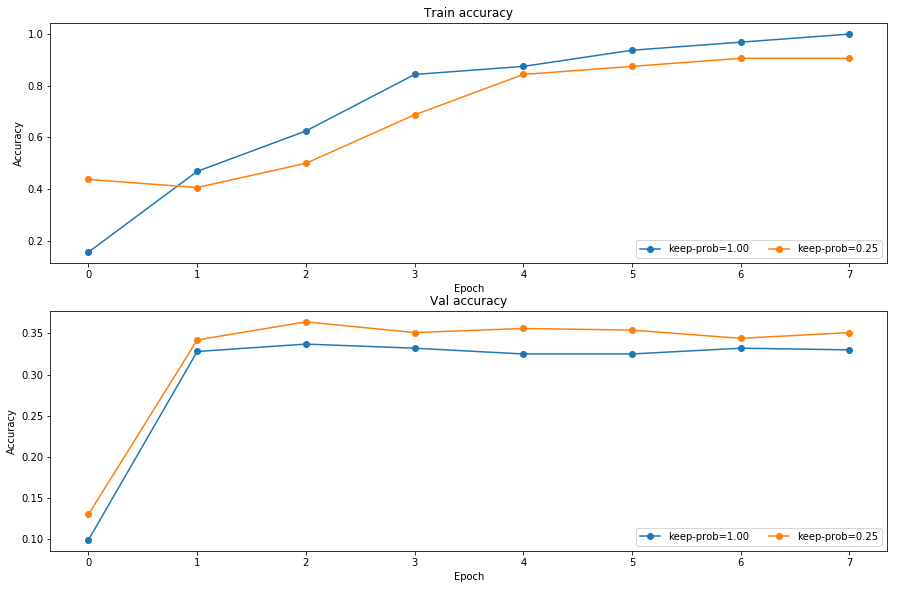

In [15]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for keep_prob in dropout_choices:
  trace = traces[keep_prob]
  train_accs.append(trace['train_acc_history'][-1])
  val_accs.append(trace['val_acc_history'][-1])

plt.subplot(3, 1, 1)
for keep_prob in dropout_choices:
  plt.plot(traces[keep_prob]['train_acc_history'], '-o', label='keep-prob=%.2f' % keep_prob)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for keep_prob in dropout_choices:
  plt.plot(traces[keep_prob]['val_acc_history'], '-o', label='keep-prob=%.2f' % keep_prob)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
It suggests that dropout is a decent regularizer. It kept the nn from overfitting judging by the lower training accuracy, and higher validation accuracy.

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
We should probably increase the keep probability (increase p) for a model with all else equal that has a lower number of nodes in each layer. Since this model is less complex it will be at a lower risk of overfitting, and a higher risk of underfitting.